In [334]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug  22 12:45:22 2016

@author: Chaofan
"""

#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

#Read the data
data = pd.read_csv('chassis_all_filled.csv')

#Remove the unique identifier ChassisNumber
data = data.ix[:, 1:]
data.head()

,Age,RelationCompany,Female,Male,CustomerType_CPR0000001,FirstDealDuration,LastDealDuration,License_1.0,Series_A1,Series_A3,...,LastHalfYearGrowthTotalAmountNormalMaintain,NormalMaintainInterval,AvgAmountNormalMaintainOverCarPrice,Last2YearTotalAmountNormalMaintainOverCarPrice,Last1YearTotalAmountNormalMaintainOverCarPrice,LastHalfYearTotalAmountNormalMaintainOverCarPrice,FirstDealMileage,LastDealMileage,AvgDealMileage,y_normal_maintain
0,40,0,0.0,0.0,1.0,22.133333,22.133333,1.0,0.0,0.0,...,0.0,24.000000,0.000000,0.000000,0.000000,0.000000,54400.0,54400.0,54400.000000,0.0
1,47,0,0.0,0.0,1.0,9.733333,3.366667,1.0,0.0,1.0,...,0.0,8.000000,0.000000,0.000000,0.000000,0.000000,11.0,6702.0,2245.333333,3338.0
2,39,0,0.0,0.0,1.0,9.966667,1.300000,0.0,0.0,1.0,...,0.0,8.000000,0.000000,0.000000,0.000000,0.000000,5.0,6358.0,2122.666667,1920.0
3,40,1,0.0,0.0,0.0,9.733333,3.733333,1.0,0.0,1.0,...,0.0,8.000000,0.000000,0.000000,0.000000,0.000000,11.0,4222.0,1418.666667,42.0
4,45,0,0.0,0.0,1.0,9.733333,5.000000,1.0,0.0,1.0,...,704.0,1.966667,0.001508,0.003016,0.003016,0.003016,11.0,10451.0,3961.000000,0.0


In [296]:
'''
Our predictors contain three kinds of information: 
    1. Customer basic personal info like age, gender etc.
    2. Customer info of Buying new cars in Yongda like car price
    3. Customer maintenance behavior involving Normal Maintenance & Repair 

Our goal is to use these predictors whose data range is between 2013.7.1 and 2015.7.1 to 
predict customers' consumption behavior of next year, namely between 2015.7.1 and 2016.7.1.

Due to the uncertainty and randomness of Repair behavior affected by too many factors, we only 
predict the total amount of Normal Maintenance, which is also called Potential Value.
'''

#Split the data into the training set and the test set
predictors = data.columns[:44]
target = 'y_normal_maintain'
X_train, X_test, y_train, y_test = train_test_split(data[predictors], data[target], test_size=0.2, random_state=6)

In [54]:
#First use Random forest as a baseline model and know about feature importances
rf = RandomForestRegressor(n_estimators=500, criterion='mse', max_features='sqrt', min_samples_leaf=50)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
rf_score = mean_squared_error(y_true=y_test, y_pred=rf_y_pred)
rf_score

6333287.2301318832

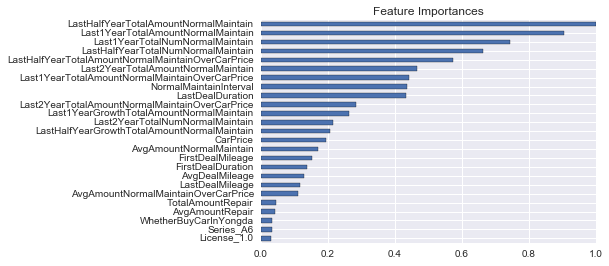

In [299]:
#Plot a graph of feature importances
importances = rf.feature_importances_
index = np.argsort(importances)[::-1]
sorted_importances = importances[index]
sorted_importances = sorted_importances / sorted_importances[0]                    
importances_v = pd.Series(sorted_importances, index=X_train.columns[index])
importances_v[:25][::-1].plot(kind='barh', title='Feature Importances')

In [303]:
#Linear model: Lasso and Ridge Regression
def lasso(X_train, y_train, X_test, y_test, params):
    lasso_scores = []
    for p in params:
        pipe_lasso = Pipeline([('scl', StandardScaler()),
                               ('lasso', Lasso(alpha=p, random_state=6))])
        pipe_lasso.fit(X_train, y_train)
        y_pred = pipe_lasso.predict(X_test)
        lasso_score = mean_squared_error(y_true=y_test, y_pred=y_pred)
        lasso_scores.append(lasso_score)
    return lasso_scores
 
def ridge(X_train, y_train, X_test, y_test, params):
    ridge_scores = []
    for p in params:
        pipe_ridge = Pipeline([('scl', StandardScaler()),
                               ('ridge', Ridge(alpha=p, random_state=6))])
        pipe_ridge.fit(X_train, y_train)
        y_pred = pipe_ridge.predict(X_test)
        ridge_score = mean_squared_error(y_true=y_test, y_pred=y_pred)
        ridge_scores.append(ridge_score)
    return ridge_scores

#Define regularization parameters tried in Lasso and Ridge regression
params = [10**x for x in np.arange(-3, 3.5, 0.5)]
params

[0.001,
 0.0031622776601683794,
 0.01,
 0.031622776601683791,
 0.10000000000000001,
 0.31622776601683794,
 1.0,
 3.1622776601683795,
 10.0,
 31.622776601683793,
 100.0,
 316.22776601683796,
 1000.0]

In [304]:
#Lasso
lasso_scores = lasso(X_train, y_train, X_test, y_test, params)
print np.argmin(lasso_scores)   #The result shows that Lasso model is underfitting the data
lasso_scores

[6652984.3531030603,
 6652986.9677100265,
 6652995.2694694521,
 6653021.8583423793,
 6653056.6128831413,
 6653122.9346670983,
 6653875.2542902976,
 6655952.3471339568,
 6668470.5583041916,
 6688227.65613678,
 6770048.3507517437,
 7005497.1288462318,
 8083949.7313785022]

In [305]:
#Ridge regression
ridge_scores = ridge(X_train, y_train, X_test, y_test, params)
print np.argmin(ridge_scores)   #The result shows that Ridge regression model is underfitting the data
ridge_scores

[6652983.1745924233,
 6652983.197289845,
 6652983.2690657135,
 6652983.4960441319,
 6652984.213844873,
 6652986.4840486813,
 6652993.6662179213,
 6653016.4088104963,
 6653088.6041821968,
 6653318.9094740599,
 6654052.1247336837,
 6656259.8094261689,
 6661766.5178340897]

In [306]:
#Handling the correlation existing among features
data[predictors].corr()

#After some exploratory analysis of the correlation, choose the following features:
new_selected_features = [
       u'LastHalfYearTotalAmountNormalMaintain',
       u'Last1YearTotalAmountNormalMaintain',
       u'Last2YearTotalAmountNormalMaintain',
       u'NormalMaintainInterval', u'LastDealDuration',
       u'Last1YearGrowthTotalAmountNormalMaintain',
       u'LastHalfYearGrowthTotalAmountNormalMaintain', u'CarPrice',
       u'AvgAmountNormalMaintain', u'FirstDealMileage', u'FirstDealDuration', u'TotalAmountRepair',
       u'WhetherBuyCarInYongda', u'Series_A6',
       u'License_1.0', u'Age', u'RelationCompany',
       u'Series_A4', u'Series_A8', u'CustomerType_CPR0000001',
       u'Male', u'Female']

In [307]:
#Lasso on data with less correlation
lasso_scores = lasso(X_train[new_selected_features], y_train, X_test[new_selected_features], y_test, params) 
lasso_scores

[6903324.7549845846,
 6903327.1109822392,
 6903334.5636449829,
 6903351.0677327551,
 6903385.7821603296,
 6903516.0785656134,
 6903649.6095686788,
 6904465.3542545205,
 6908427.8374851709,
 6921739.2775032585,
 7004898.7493457636,
 7243767.6821083743,
 8354409.0672098333]

In [308]:
#Ridge regression on data with less correlation
ridge_scores = ridge(X_train[new_selected_features], y_train, X_test[new_selected_features], y_test, params)  
ridge_scores

[6903323.6656943094,
 6903323.6660834914,
 6903323.6673142118,
 6903323.6712062797,
 6903323.6835159371,
 6903323.7224611398,
 6903323.8458030848,
 6903324.2377079073,
 6903325.4956316343,
 6903329.6589745274,
 6903344.6577529302,
 6903409.7706626216,
 6903774.1095065437]

In [ ]:
'''
Inference:
As we have little useful and valid variables which are very predictive of the target and most of our features are 
categorical variables, removing some correlated variables undermines the model performance instead.
'''

In [309]:
#Select relatively important features obtained from Random Forest Feature Importance Table
selected_features = X_train.columns[index][importances_v > 0.01]

#Add polynomial features and increase the model flexibility or complexity of Lasso / Ridge regression
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
quad = PolynomialFeatures(2)
X_train_quad = quad.fit_transform(X_train_selected)
X_test_quad = quad.fit_transform(X_test_selected)
X_train_quad.shape

(43108, 496)

In [314]:
#Lasso on data with polynomial features
new_params1 = np.arange(1, 10, 0.5)
lasso_scores = lasso(X_train_quad, y_train, X_test_quad, y_test, new_params1)
'Best regularization param:', np.argmin(lasso_scores), lasso_scores, 'Best Score:', lasso_scores[np.argmin(lasso_scores)]

('Best regularization param:',
 3,
 [6388115.4940900747,
  6381236.9000865621,
  6377729.9502811963,
  6376152.7144667003,
  6377687.2727549179,
  6379822.3472403567,
  6381803.5090710251,
  6383034.6814392507,
  6384290.9621616676,
  6385562.131338289,
  6387041.6692997897,
  6388861.1138859391,
  6390966.2541429484,
  6393364.5492462246,
  6395645.5231225379,
  6398037.9820227334,
  6400582.6654128833,
  6403601.6088742577],
 'Best Score:',
 6376152.7144667003)

In [315]:
#Ridge regression on data with polynomial features
new_params2 = [0] + [10**x for x in np.arange(2.5, 4.5, 0.15)]
ridge_scores = ridge(X_train_quad, y_train, X_test_quad, y_test, new_params2)
'Best regularization param:', np.argmin(ridge_scores), ridge_scores, 'Best Score:', ridge_scores[np.argmin(ridge_scores)]

('Best regularization param:',
 5,
 [6548691.1096511586,
  6391310.9937557941,
  6387060.4001040822,
  6383968.6851780461,
  6382303.3692351114,
  6382266.5966404099,
  6384051.0418323232,
  6387865.0373920416,
  6393922.3508935515,
  6402428.9506163914,
  6413597.0515092658,
  6427679.1988689238,
  6444978.427355052,
  6465793.6732759234,
  6490311.2504712585],
 'Best Score:',
 6382266.5966404099)

In [ ]:
'''
Inference:
Compared with simple linear models, Lasso and Ridge regression with polynomial features do bring some model 
improvements. But they still can not beat the baseline Random Forest model which is not even optimized.
'''

In [188]:
#Now let's tune the parameters of Random Forest model to see if the model performance can be improved
param_grid = {'n_estimators': [800, 1000, 1200],
              'max_features': [0.6, 0.7, 0.85, 1.0],
              'min_samples_leaf': [20, 30, 35]}
gs = GridSearchCV(estimator=RandomForestRegressor(verbose=2, random_state=6),
                  param_grid=param_grid,
                  scoring='mean_squared_error',
                  cv=5)
gs.fit(X_train, y_train)
print gs.best_score_
print gs.best_params_
best_rf = gs.best_estimator_
best_rf.fit(X_train, y_train)
best_rf_pred = best_rf.predict(X_test)
best_rf_score = mean_squared_error(y_true=y_test, y_pred=best_rf_pred)
best_rf_score

6264383.3905871734

In [191]:
gs.best_params_, gs.best_score_, 

({'max_features': 0.7, 'min_samples_leaf': 20, 'n_estimators': 800},
 -6310491.6857147701)

In [214]:
'''
Tuning three parameters at the same time using a large number of estimators costs too much time.
Let's find the optimal other 2 parameters first and then tune the 'n_estimators' parameter.    
'''
param_test1 = {'min_samples_leaf': range(1, 25, 3),
               'max_features': ['sqrt', 0.7]}
gs1 = GridSearchCV(estimator=RandomForestRegressor(n_estimators=100, verbose=2, random_state=6),
                   param_grid=param_test1,
                   scoring='mean_squared_error',
                   iid=False,
                   n_jobs=-1,
                   cv=5)
gs1.fit(X_train, y_train)
best_rf1 = gs1.best_estimator_
best_rf1.fit(X_train, y_train)
best_rf1_pred = best_rf1.predict(X_test)
best_rf1_score = mean_squared_error(y_true=y_test, y_pred=best_rf1_pred)
gs1.best_params_, gs1.best_score_, best_rf1_score

({'max_features': 0.7, 'min_samples_leaf': 19},
 -6322245.0535773067,
 6266229.3916941769)

In [215]:
param_test2 = {'min_samples_leaf': [17, 19, 21],
               'max_features': [0.5, 0.7, 0.9]}
gs2 = GridSearchCV(estimator=RandomForestRegressor(n_estimators=200, verbose=2, random_state=6),
                   param_grid=param_test2,
                   scoring='mean_squared_error',
                   iid=False,
                   n_jobs=-1,
                   cv=5)
gs2.fit(X_train, y_train)
best_rf2 = gs2.best_estimator_
best_rf2.fit(X_train, y_train)
best_rf2_pred = best_rf2.predict(X_test)
best_rf2_score = mean_squared_error(y_true=y_test, y_pred=best_rf2_pred)
gs2.best_params_, gs2.best_score_, best_rf2_score

({'max_features': 0.7, 'min_samples_leaf': 21},
 -6312059.2987947417,
 6268516.8824807396)

In [ ]:
#Test how to set the n_jobs parameter to run the algorithm faster
model1 = RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=1)
%timeit model1.fit(X_train, y_train)
model2 = RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=-1)
%timeit model2.fit(X_train, y_train)

In [220]:
#To save time, use OOB estimate instead of using cross-validation in Grid Search
param_test3 = {'n_estimators': [1000, 1500, 2000],
               'min_samples_leaf': [16, 20, 25, 30, 50]}
rf_3_scores = []
for n in param_test3['n_estimators']:
    for m_leaf in param_test3['min_samples_leaf']:
        rf_3 = RandomForestRegressor(max_features=0.7, 
                                     n_estimators=n, 
                                     min_samples_leaf=m_leaf,
                                     oob_score=True,
                                     n_jobs=-1,
                                     verbose=2, 
                                     random_state=6)
        rf_3.fit(X_train, y_train)
        mse = mean_squared_error(y_true=y_test, y_pred=rf_3.predict(X_test))
        rf_3_scores.append((n, m_leaf, rf_3.oob_score_, mse))
rf_3_scores

[(1000, 16, 0.31615258633452359, 6265164.8641532045),
 (1000, 20, 0.31618532541843425, 6263255.1292925635),
 (1000, 25, 0.31653472580291364, 6262816.1781266294),
 (1000, 30, 0.31600470074494968, 6271315.3161689714),
 (1000, 50, 0.31404918435010887, 6291627.5156894075),
 (1500, 16, 0.31638610394657118, 6265499.6306616766),
 (1500, 20, 0.3162420307941487, 6263591.2222079989),
 (1500, 25, 0.31645588233995581, 6264082.8842298547),
 (1500, 30, 0.31606570102645382, 6269844.7398880571),
 (1500, 50, 0.31426066931332408, 6290573.6230317559),
 (2000, 16, 0.3164991765635865, 6263769.2497870214),
 (2000, 20, 0.316310475898954, 6263991.1630481733),
 (2000, 25, 0.31643791899191609, 6264311.2321118098),
 (2000, 30, 0.31619194631499437, 6270245.1494099321),
 (2000, 50, 0.31425625108203015, 6289648.4674421018)]

In [330]:
param_test4 = {'n_estimators': range(800, 1101, 100)}
rf_4_scores = []
for n in param_test4['n_estimators']:
    rf_4 = RandomForestRegressor(max_features=0.7, 
                                 n_estimators=n, 
                                 min_samples_leaf=25,
                                 oob_score=True,
                                 n_jobs=-1,
                                 verbose=2, 
                                 random_state=6)
    rf_4.fit(X_train, y_train)
    mse = mean_squared_error(y_true=y_test, y_pred=rf_4.predict(X_test))
    rf_4_scores.append((n, rf_4.oob_score_, mse))
rf_4_scores

[(800, 0.31642956699827673, 6264001.6420100871),
 (900, 0.31658416674441414, 6263837.9040705133),
 (1000, 0.31653472580291364, 6262816.1781266294),
 (1100, 0.31660692350028685, 6264296.7375799362)]

In [331]:
'''
Conclusion:
Random Forest model can have a better performance with about 6260000 MSE compated with the Lasso performance 
with 6370000 MSE. 

The model performance improves by 2%.
'''

0.0086718231785571556

In [ ]:
'''
Now Let's try Gradient Boosting Algorithm.
'''

In [229]:
#Step 1: tune the boosting parameters: learning_rate & n_estimators

#Fix the learning_rate and find the best n_estimators
param_test1 = {'n_estimators': range(20, 81, 10)}
gsearch1 = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.1, max_depth=8, min_samples_split=500, min_samples_leaf=50, max_features='sqrt', subsample=0.8, random_state=6, verbose=2),
                        param_grid=param_test1,
                        scoring='mean_squared_error',
                        cv=5,
                        iid=False,
                        n_jobs=4,
                        verbose=2)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -6450015.61779, std: 208857.11954, params: {'n_estimators': 20},
  mean: -6358543.17456, std: 211333.33449, params: {'n_estimators': 30},
  mean: -6337872.98428, std: 217134.45286, params: {'n_estimators': 40},
  mean: -6328127.51084, std: 219842.69593, params: {'n_estimators': 50},
  mean: -6326775.98646, std: 220775.34319, params: {'n_estimators': 60},
  mean: -6326709.95327, std: 219266.00859, params: {'n_estimators': 70},
  mean: -6328269.37558, std: 220450.22523, params: {'n_estimators': 80}],
 {'n_estimators': 70},
 -6326709.953265423)

In [230]:
mean_squared_error(y_test, gsearch1.best_estimator_.predict(X_test))

6294097.4898872161

In [231]:
#Step 2: tune the tree parameters: 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features'
param_test2 = {'max_depth': range(5, 16, 2), 'min_samples_split': range(200, 1001, 200)}
gsearch2 = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.1, n_estimators=70, max_features='sqrt', subsample=0.8, random_state=6, verbose=2),
                        param_grid=param_test2,
                        scoring='mean_squared_error',
                        cv=5,
                        iid=False,
                        n_jobs=4,
                        verbose=2)
gsearch2.fit(X_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: -6390564.92327, std: 211227.79792, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: -6382137.47183, std: 200625.82828, params: {'min_samples_split': 400, 'max_depth': 5},
  mean: -6408965.03257, std: 211308.81819, params: {'min_samples_split': 600, 'max_depth': 5},
  mean: -6392485.17975, std: 210164.33479, params: {'min_samples_split': 800, 'max_depth': 5},
  mean: -6388302.93097, std: 205918.77160, params: {'min_samples_split': 1000, 'max_depth': 5},
  mean: -6365733.57223, std: 214821.87466, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: -6354499.19180, std: 205532.37202, params: {'min_samples_split': 400, 'max_depth': 7},
  mean: -6353519.62221, std: 221161.91356, params: {'min_samples_split': 600, 'max_depth': 7},
  mean: -6353140.13471, std: 215587.72905, params: {'min_samples_split': 800, 'max_depth': 7},
  mean: -6363961.30520, std: 227043.12758, params: {'min_samples_split': 1000, 'max_depth': 7},
  mean: -6378122.49095, std: 217661.29188, param

In [232]:
mean_squared_error(y_test, gsearch2.best_estimator_.predict(X_test))

6280221.7409751248

In [234]:
param_test3 = {'min_samples_leaf': range(10, 71, 10), 'max_features': ['sqrt', 0.5, 0.6, 0.7, 0.8, 0.9]}
gsearch3 = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.1, n_estimators=70, max_depth=9, min_samples_split=600, subsample=0.8, random_state=6, verbose=2),
                        param_grid=param_test3,
                        scoring='mean_squared_error',
                        cv=5,
                        iid=False,
                        n_jobs=4,
                        verbose=2)
gsearch3.fit(X_train, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -6338852.42785, std: 202442.26811, params: {'max_features': 'sqrt', 'min_samples_leaf': 10},
  mean: -6319610.32688, std: 212232.33122, params: {'max_features': 'sqrt', 'min_samples_leaf': 20},
  mean: -6322488.50938, std: 213408.92797, params: {'max_features': 'sqrt', 'min_samples_leaf': 30},
  mean: -6307222.52016, std: 212179.98073, params: {'max_features': 'sqrt', 'min_samples_leaf': 40},
  mean: -6312117.51953, std: 204466.70901, params: {'max_features': 'sqrt', 'min_samples_leaf': 50},
  mean: -6315562.35976, std: 215364.06405, params: {'max_features': 'sqrt', 'min_samples_leaf': 60},
  mean: -6306467.92646, std: 199735.50965, params: {'max_features': 'sqrt', 'min_samples_leaf': 70},
  mean: -6353893.12762, std: 189440.60142, params: {'max_features': 0.5, 'min_samples_leaf': 10},
  mean: -6342160.65140, std: 217884.26361, params: {'max_features': 0.5, 'min_samples_leaf': 20},
  mean: -6325384.12073, std: 217656.00033, params: {'max_features': 0.5, 'min_samples_leaf': 30},

In [239]:
mean_squared_error(y_test, gsearch3.best_estimator_.predict(X_test))

6278126.1497043557

In [238]:
param_test4 = {'min_samples_leaf': range(70, 101, 10), 'max_features': range(2, 16, 2)}
gsearch4 = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.1, n_estimators=70, max_depth=9, min_samples_split=600, subsample=0.8, random_state=6, verbose=2),
                        param_grid=param_test4,
                        scoring='mean_squared_error',
                        cv=5,
                        iid=False,
                        n_jobs=-1,
                        verbose=2)
gsearch4.fit(X_train, y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -6338325.33982, std: 219960.35318, params: {'max_features': 2, 'min_samples_leaf': 70},
  mean: -6342575.25968, std: 204126.98098, params: {'max_features': 2, 'min_samples_leaf': 80},
  mean: -6345962.61769, std: 203383.30546, params: {'max_features': 2, 'min_samples_leaf': 90},
  mean: -6345675.17932, std: 216805.02978, params: {'max_features': 2, 'min_samples_leaf': 100},
  mean: -6324220.85532, std: 219288.80493, params: {'max_features': 4, 'min_samples_leaf': 70},
  mean: -6328296.01811, std: 217044.47313, params: {'max_features': 4, 'min_samples_leaf': 80},
  mean: -6318862.52898, std: 223635.59875, params: {'max_features': 4, 'min_samples_leaf': 90},
  mean: -6332230.86536, std: 216323.86464, params: {'max_features': 4, 'min_samples_leaf': 100},
  mean: -6306467.92646, std: 199735.50965, params: {'max_features': 6, 'min_samples_leaf': 70},
  mean: -6300088.51020, std: 222267.35791, params: {'max_features': 6, 'min_samples_leaf': 80},
  mean: -6302559.49424, std: 201700.11

In [240]:
mean_squared_error(y_test, gsearch4.best_estimator_.predict(X_test))

6239399.8027937682

In [241]:
param_test5 = {'min_samples_leaf': range(100, 201, 10)}
gsearch5 = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.1, n_estimators=70, max_depth=9, min_samples_split=600, max_features=10, subsample=0.8, random_state=6, verbose=2),
                        param_grid=param_test5,
                        scoring='mean_squared_error',
                        cv=5,
                        iid=False,
                        n_jobs=-1,
                        verbose=2)
gsearch5.fit(X_train, y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: -6294469.29641, std: 222053.72599, params: {'min_samples_leaf': 100},
  mean: -6310173.90853, std: 224812.07748, params: {'min_samples_leaf': 110},
  mean: -6312138.70864, std: 227677.77868, params: {'min_samples_leaf': 120},
  mean: -6304752.01710, std: 205067.19401, params: {'min_samples_leaf': 130},
  mean: -6298015.46822, std: 221626.89476, params: {'min_samples_leaf': 140},
  mean: -6308521.22643, std: 218673.79576, params: {'min_samples_leaf': 150},
  mean: -6303332.30696, std: 222507.88041, params: {'min_samples_leaf': 160},
  mean: -6299993.18832, std: 217771.07132, params: {'min_samples_leaf': 170},
  mean: -6297274.11813, std: 219705.73351, params: {'min_samples_leaf': 180},
  mean: -6298663.03883, std: 215849.68177, params: {'min_samples_leaf': 190},
  mean: -6308199.31040, std: 208140.62457, params: {'min_samples_leaf': 200}],
 {'min_samples_leaf': 100},
 -6294469.2964092093)

In [242]:
#Step 3: tune the 'subsample' parameter so as to lower the learning rate
param_test6 = {'subsample': [0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch6 = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.1, n_estimators=70, max_depth=9, min_samples_split=600, min_samples_leaf=100, max_features=10, random_state=6, verbose=2),
                        param_grid=param_test6,
                        scoring='mean_squared_error',
                        cv=5,
                        iid=False,
                        n_jobs=-1,
                        verbose=2)
gsearch6.fit(X_train, y_train)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: -6326154.04182, std: 222115.83087, params: {'subsample': 0.6},
  mean: -6306340.72169, std: 224320.33033, params: {'subsample': 0.7},
  mean: -6311862.13002, std: 212917.41246, params: {'subsample': 0.75},
  mean: -6294469.29641, std: 222053.72599, params: {'subsample': 0.8},
  mean: -6307176.55834, std: 231585.26238, params: {'subsample': 0.85},
  mean: -6303017.99256, std: 216325.89165, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 -6294469.2964092093)

In [278]:
mean_squared_error(y_test, gsearch6.best_estimator_.predict(X_test))

6239399.8027937682

In [245]:
#Step final: tune the learning_rate & n_estimators
gbm_tuned_1 = GradientBoostingRegressor(learning_rate=0.05, n_estimators=140, max_depth=9, min_samples_split=600, min_samples_leaf=100, max_features=10, subsample=0.8, random_state=6, verbose=2)
gbm_tuned_1.fit(X_train, y_train)
mean_squared_error(y_test, gbm_tuned_1.predict(X_test))                     

6242140.835350927

In [246]:
gbm_tuned_2 = GradientBoostingRegressor(learning_rate=0.025, n_estimators=280, max_depth=9, min_samples_split=600, min_samples_leaf=100, max_features=10, subsample=0.8, random_state=6, verbose=2)
gbm_tuned_2.fit(X_train, y_train)
mean_squared_error(y_test, gbm_tuned_2.predict(X_test))  

6232833.6086429721

In [247]:
gbm_tuned_3 = GradientBoostingRegressor(learning_rate=0.01, n_estimators=700, max_depth=9, min_samples_split=600, min_samples_leaf=100, max_features=10, subsample=0.8, random_state=6, verbose=2)
gbm_tuned_3.fit(X_train, y_train)
mean_squared_error(y_test, gbm_tuned_3.predict(X_test)) 

6226484.961615175

In [248]:
gbm_tuned_4 = GradientBoostingRegressor(learning_rate=0.005, n_estimators=1400, max_depth=9, min_samples_split=600, min_samples_leaf=100, max_features=10, subsample=0.8, random_state=6, verbose=2)
gbm_tuned_4.fit(X_train, y_train)
mean_squared_error(y_test, gbm_tuned_4.predict(X_test)) 

6225068.1732226005

In [249]:
gbm_tuned_5 = GradientBoostingRegressor(learning_rate=0.0025, n_estimators=2800, max_depth=9, min_samples_split=600, min_samples_leaf=100, max_features=10, subsample=0.8, random_state=6, warm_start=True, verbose=2)
gbm_tuned_5.fit(X_train, y_train)
mean_squared_error(y_test, gbm_tuned_5.predict(X_test)) 

6221714.3353606537

In [ ]:
'''
Conclusion:
Gradient Boosting model can have a better performance with about a MSE of 6220000 compated with the Random Forest 
performance with a MSE of 6260000. 

The model performance improves by 0.64%.
'''

In [336]:
#Try a different metric to see the performance of our tuned model
r2_score(y_test, gbm_tuned_5.predict(X_test))

0.31439256840480667

In [ ]:
'''
Summary:

From the R^2 score, we can see that only about 30% of the target variable can be explained by our predictors. I think 
that the most important reason why this trained model doesn't perform very well is that there is a lack of valid 
strong or at least relatively relevant predictors. For example, the occupation or annual income of a customer is 
more predictive than the age or gender. All we have which is related to the target variable is the behavior of 
customers' maintenance. Besides, many of the predictors have tons of missing values, sometimes reaching almost half 
the total data, and erroneous data entries which interior staff of Yongda company can not even distinguish. 

However, compared with my colleagues' previous work, I have improved the model performance from a MSE of about 8000000
to a MSE of about 6000000 through creative data preprocessing and feature engineering which are as follows:
    1. Handling incorrect data entries 
    2. Adding new features like consumption behavior features related to the last half year
    3. More careful way of handling missing data

In the end, an improvement of 30% in MSE is a progress which can not be ignored.
'''